In [1]:
import os

import cfGPR
import vonkarman as vk
import treecorr

import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as c
import scipy.optimize as opt

In [2]:
def getGrid(X1, X2):
    u1, u2 = X1[:, 0], X2[:, 0]
    v1, v2 = X1[:, 1], X2[:, 1]
    uu1, uu2 = np.meshgrid(u1, u2)
    vv1, vv2 = np.meshgrid(v1, v2)
    
    return uu1 - uu2, vv1 - vv2

In [3]:
def fit_vonKarman(X, variance, outerScale, diameter, wind_x, wind_y):
    
    theta = {
        'var': variance,
        'oS': outerScale,
        'd': diameter,
        'wind_x': wind_x,
        'wind_y': wind_y
    }
    params = ' '.join([f"{name:>8}: {x:<15.5f}" for name, x in theta.items()])
    with open(os.path.join(GP.outdir, "params.out"), mode='a+') as file:
        file.write(params + '\n')
    
    # Undo formatting of the grid.
    xx = X[0].reshape((int(np.sqrt(X[0].shape[0])), int(np.sqrt(X[0].shape[0]))))
    yy = X[1].reshape((int(np.sqrt(X[1].shape[0])), int(np.sqrt(X[1].shape[0]))))
    
    # Initialize an instance of the TubulentLayer class in order to
    # calculate the covariance function on the grid for the given parameters.
    ttt = vk.TurbulentLayer(
        variance=variance,
        outerScale=outerScale,
        diameter=diameter,
        wind=(wind_x, wind_y))
    
    # Caulculate covariance function, xi_plus, and return it.
    Cuv = ttt.getCuv(xx, yy)
    xiplus = Cuv[:, :, 0, 0] + Cuv[:, :, 1, 1]
    
    return xiplus.ravel(order='C')

In [4]:
maxSeparation = (5*u.arcmin).to(u.deg).value
nBins = 50

# Generate Cuv on a grid
dx = maxSeparation / (nBins / 2) 
x = np.arange(-nBins / 2, nBins / 2) * dx
xx, yy = np.meshgrid(x, x)
X = np.vstack([xx.ravel(), yy.ravel()])

p0 = np.array([
    200,
    1,
    .1,
    0,
    0
])

bounds = np.array([
    (1, 1000),
    (0.1, 20),
    (0.001, 1),
    (-10, 10),
    (-10, 10),
]).T

/home/fortino/DESworkspace/vonkarman.py:183: RuntimeWarning: divide by zero encountered in log
  return  self.interpolator(np.log(r))


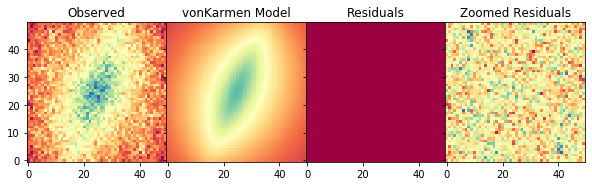

/home/fortino/DESworkspace/vonkarman.py:116: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  i0 =  quad(integrand,self.kMin,self.kMax,limit=200)[0]
/home/fortino/DESworkspace/vonkarman.py:120: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  i2 =  quad(integrand,self.kMin,self.kMax,limit=200)[0]
/home/fortino/DESworkspace/vonkarman.py:116: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If t

In [ ]:
exposures = np.arange(454, 500)
for exposure in exposures:

    # Load data to be fit.
    GP = cfGPR.CurlFreeGPR(f"../vkexposures/{exposure}")
    GP.load_fits('folio2')
    GP.extract_data(exposure)
    GP.sigma_clip()
    GP.split_data(train_size=0.5)

    # Calculate the 2pt correlation function of the entire dataset.
    xiplus, counts = cfGPR.vcorr2d(GP.X[:, 0], GP.X[:, 1], GP.Y[:, 0], GP.Y[:, 1], rmax=maxSeparation, bins=nBins)
    formatted_xiplus = xiplus.ravel(order='C')

    # Run the optimizer.
    popt, pcov = opt.curve_fit(
        fit_vonKarman,
        X,
        formatted_xiplus,
        p0=p0,
        bounds=bounds)

    # Initialize a von Karman model with the parameters from the optimizer.
    ttt = vk.TurbulentLayer(
        variance=popt[0],
        outerScale=popt[1],
        diameter=popt[2],
        wind=(popt[3], popt[4]))

    # Evaluate the covariance function on a grid for plotting.
    Cuv_model = ttt.getCuv(xx, yy)
    xiplus_model = Cuv_model[:, :, 0, 0] + Cuv_model[:, :, 1, 1]

    # Plot the 2pt correlation function of the observed data, the fitted model, the difference of the two,
    # and a closeup of the difference. This helps evaluate the fit.
    fig, axes = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(10, 5))
    fig.subplots_adjust(wspace=0)

    axes[0].imshow(xiplus, origin='lower', cmap='Spectral', interpolation='nearest', vmin=xiplus.min(), vmax=xiplus.max())
    axes[0].set_title("Observed")

    axes[1].imshow(xiplus_model, origin='lower', cmap='Spectral', interpolation='nearest', vmin=xiplus.min(), vmax=xiplus.max())
    axes[1].set_title("vonKarmen Model")

    im = axes[2].imshow(xiplus - xiplus_model, origin='lower', cmap='Spectral', interpolation='nearest', vmin=xiplus.min(), vmax=xiplus.max())
    axes[2].set_title("Residuals")
#     fig.colorbar(im, ax=axes[2])

    im = axes[3].imshow(xiplus - xiplus_model, origin='lower', cmap='Spectral', interpolation='nearest')
    axes[3].set_title("Zoomed Residuals")
#     fig.colorbar(im, ax=axes[3])
    
    plt.savefig((os.path.join(GP.outdir, "2pt_compare.pdf")))

    plt.show()


    # Calculate K
    du, dv = getGrid(GP.Xtrain, GP.Xtrain)
    Cuv = ttt.getCuv(du, dv)
    K = np.moveaxis(Cuv, 2, 1)
    s = K.shape
    K = K.reshape(s[0]*2, s[2]*2)

    # Calculate Ks
    du, dv = getGrid(GP.Xtest, GP.Xtrain)
    Cuv = ttt.getCuv(du, dv)
    Ks = np.moveaxis(Cuv, 2, 1)
    s = Ks.shape
    Ks = Ks.reshape(s[0]*2, s[2]*2)

    # Calculate W
    W = GP.white_noise_kernel(GP.Etrain)

    # Calculate the posterior predictive mean
    GP.fbar_s = GP.unflat(np.dot(np.dot(Ks.T, np.linalg.inv(K + W)), GP.flat(GP.Ytrain)))

    # Make plots
    GP.wrap()
#     GP.plot_residuals(GP.Xtest, GP.Ytest, GP.Etest, save=True)
#     GP.plot_residuals(GP.Xtest, GP.Ytest - GP.fbar_s, GP.Etest, save=True, ext='GPR_applied_')

#     GP.plot_div_curl(GP.Xtest, GP.Ytest, GP.Etest, save=True)
#     GP.plot_div_curl(GP.Xtest, GP.Ytest - GP.fbar_s, GP.Etest, save=True, ext='GPR_applied_')

#     GP.plot_Emode_2ptcorr(GP.Xtest, GP.Ytest, Y2=GP.Ytest - GP.fbar_s, save=True)
#     GP.plot_xiplus_2d(GP.Xtest, GP.Ytest, Y2=GP.fbar_s, save=True)